In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# **Question 1**

## Regresion tree

In [159]:
def gini_index(groups, output_values):
  gini = 0.0
  for output in output_values:
    for group in groups:
      if(len(group)!=0):
        p = [row[0] for row in group].count(output) / float(len(group))
        gini += p*(1-p)
  return gini

def test_split(df,index,threshold):
  left = list()
  right = list()
  for row in df:
    if row[index] < threshold:
      left.append(row)
    else:
      right.append(row)
  return left, right

def get_split(df):
  output_values = list(set(row[0] for row in df))
  maxx = {}
  max_score = 1e9
  for index in range(len(df[0])-1):
    for row in df:
      groups = test_split(df, index, row[index])
      gini = gini_index(groups, output_values)
      if gini < max_score:
        maxx['index'], maxx['value'], maxx['score'], maxx['groups'] = index, row[index], gini, groups
  return maxx

def leaf(group):
  for group1 in group:
    res = [row[0] for row in group1 if len(row)!=0]
  return max(set(res), key=res.count)

def split(node, max_depth, min_size, curr_depth):
  left = node['groups']
  right = node['groups']
  if(not(left) or not(right)):
    node['left'] = node['right'] = leaf(left + right)
    return
  if curr_depth >= max_depth : 
    node['left'], node['right'] = leaf(left), leaf(right)
    return
  else:
    node['left'] = get_split(left)
    split(node['left'], max_depth, min_size, curr_depth+1)
  if len(right) <= min_size :
    node['right'] = leaf(right)
  else:
    node['right'] = get_split(right)
    split(node['right'], max_depth, min_size, curr_depth+1)

def build_tree(train, max_depth=5, min_size=2):
  root = get_split(train)
  print("root",root)
  split(root, max_depth, min_size, 1)
  return root

def predict(row,node):
  if row[node['index']] < node['value']:
    if isinstance(node['left'], dict):
      return predict(node['left'], row)
    else:
      return node['left']
  else:
    if isinstance(node['right'], dict):
      return predict(node['right'], row)
    else:
      return node['right']

## Pre-processing

In [160]:
housing_df = pd.read_csv('Housing.csv')
housing_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [161]:
housing_df.shape

(545, 13)

In [162]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [163]:
housing_df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [164]:
housing_df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [165]:
# changin yes/no values to 1 and 0
yes_no = ['mainroad', 'guestroom',	'basement',	'hotwaterheating',	'airconditioning', 'prefarea']
for i in yes_no:
  housing_df[i] = housing_df[i].map({'yes': 1, 'no': 0})
housing_df['furnishingstatus'] = housing_df['furnishingstatus'].map({'furnished': 2, 'semi-furnished': 1, 'unfurnished':0})
housing_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,2


In [166]:
# scaling the reuired fields
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_col = ['price','area']
scale_col
housing_df[scale_col] = scaler.fit_transform(housing_df[scale_col])
housing_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,1.000000,0.396564,4,2,3,1,0,0,0,1,2,1,2
1,0.909091,0.502405,4,4,4,1,0,0,0,1,3,0,2
2,0.909091,0.571134,3,2,2,1,0,1,0,0,2,1,1
3,0.906061,0.402062,4,2,2,1,0,1,0,1,3,1,2
4,0.836364,0.396564,4,1,2,1,1,1,0,1,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0.006061,0.092784,2,1,1,1,0,1,0,0,2,0,0
541,0.001485,0.051546,3,1,1,0,0,0,0,0,0,0,1
542,0.000000,0.135395,2,1,1,1,0,0,0,0,0,0,0
543,0.000000,0.086598,3,1,1,0,0,0,0,0,0,0,2


In [167]:
housing_df.nunique()

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64

In [168]:
status = pd.get_dummies(housing_df['furnishingstatus'], drop_first = True)
housing_df = pd.concat([housing_df, status], axis = 1)
housing_df.drop(['furnishingstatus'], axis = 1, inplace = True)
housing_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,1,2
0,1.000000,0.396564,4,2,3,1,0,0,0,1,2,1,0,1
1,0.909091,0.502405,4,4,4,1,0,0,0,1,3,0,0,1
2,0.909091,0.571134,3,2,2,1,0,1,0,0,2,1,1,0
3,0.906061,0.402062,4,2,2,1,0,1,0,1,3,1,0,1
4,0.836364,0.396564,4,1,2,1,1,1,0,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0.006061,0.092784,2,1,1,1,0,1,0,0,2,0,0,0
541,0.001485,0.051546,3,1,1,0,0,0,0,0,0,0,1,0
542,0.000000,0.135395,2,1,1,1,0,0,0,0,0,0,0,0
543,0.000000,0.086598,3,1,1,0,0,0,0,0,0,0,0,1


## Visualisation

In [169]:
# sns.set_style("whitegrid");
# sns.pairplot(housing_df, size=3);
# plt.show()

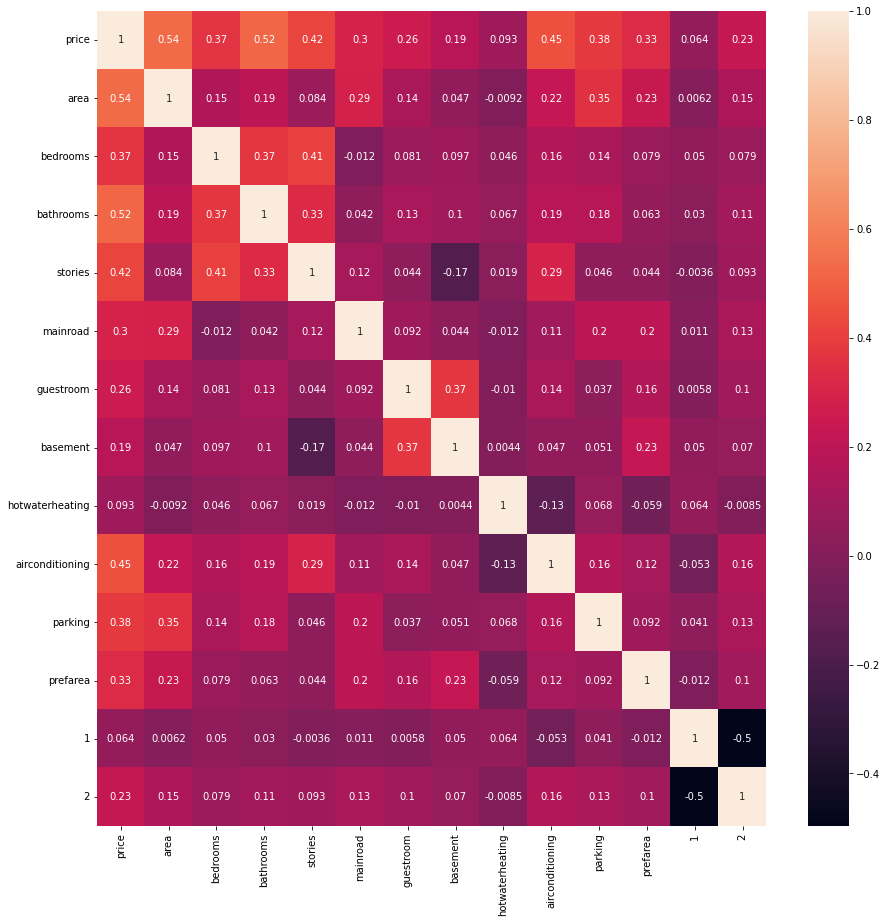

In [170]:
plt.figure(figsize=(15,15))
correlation_matrix = housing_df.corr()
sns.heatmap(data=correlation_matrix, annot=True)
# price is mostly related to area, bathrooms and air conditioning

## 1.1

In [171]:
X = housing_df.iloc[:, 1:]
Y = housing_df.iloc[:, 0]
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3,random_state=7)
X_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,1,2
235,0.276976,3,1,2,1,1,0,0,1,1,0,1,0
384,0.195876,2,1,1,0,0,0,0,0,0,0,0,1
41,0.323711,3,2,4,1,0,0,0,1,0,1,0,1
328,0.195876,3,2,2,0,0,1,0,1,0,0,1,0
330,0.164948,2,1,2,1,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.773196,3,1,1,1,0,0,0,0,2,0,0,1
502,0.125773,2,1,1,1,0,0,0,0,1,0,1,0
537,0.003436,3,1,2,1,0,0,0,0,0,0,0,0
196,0.414845,3,1,1,1,1,1,1,0,0,0,1,0


In [172]:
Y_train.head()

235    0.248485
384    0.157576
41     0.527273
328    0.193939
330    0.193939
Name: price, dtype: float64

In [173]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
train = np.array(pd.concat([Y_train,X_train],axis=1))

# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
# regressor = build_tree(train)
  
# fit the regressor with X and Y data
regressor.fit(X_train,Y_train)

Y_pred = regressor.predict(X_test)
Y_pred

array([0.0969697 , 0.42121212, 0.11818182, 0.21212121, 0.13939394,
       0.45757576, 0.33333333, 0.12060606, 0.44242424, 0.35151515,
       0.03030303, 0.12060606, 0.25454545, 0.0969697 , 0.27272727,
       0.03333333, 0.37575758, 0.37575758, 0.20606061, 0.18484848,
       0.12727273, 0.24242424, 0.59090909, 0.17575758, 0.18484848,
       0.12060606, 0.27272727, 0.15151515, 0.16666667, 0.35151515,
       0.14545455, 0.11515152, 0.19393939, 0.27272727, 0.28484848,
       0.24181818, 0.35636364, 0.47575758, 0.23575758, 0.17575758,
       0.3569697 , 0.18484848, 0.1969697 , 0.07878788, 0.15151515,
       0.21212121, 0.23636364, 0.13333333, 0.18484848, 0.27575758,
       0.44242424, 0.12060606, 0.21212121, 0.13636364, 0.1469697 ,
       0.12727273, 0.34545455, 0.5030303 , 0.45757576, 0.16363636,
       0.18181818, 0.33787879, 0.16666667, 0.19393939, 0.09393939,
       0.7030303 , 0.13333333, 0.30909091, 0.1030303 , 0.18787879,
       0.36363636, 0.21212121, 0.12121212, 0.72727273, 0.10303

In [174]:
Y_test1 = Y_test.values.tolist()
Y_pred1 = Y_pred.tolist()

# mean-squared error
def error_mse(actual,pred):
  errors_mse = list()
  for i in range(len(actual)):
    err = (actual[i] - pred[i])**2
    errors_mse.append(err)
  return (sum(errors_mse)/len(errors_mse))
error_mse(Y_test1,Y_pred1)

0.020418831888732114

In [175]:
# mean absolute error
def error_mae(actual,pred):
  errors_mae = list()
  for i in range(len(actual)):
    err = abs(actual[i] - pred[i])
    errors_mae.append(err)
  return (sum(errors_mae)/len(errors_mae))

error_mae(Y_test1,Y_pred1)

0.09775129342202515

In [176]:
# r2 score
def error_r2(actual,pred):
  errors_r2 = list()
  den = list()
  mean_act = sum(actual)/len(actual)
  for i in range(len(actual)):
    err = (actual[i] - pred[i])
    errors_r2.append(err**2)
    den.append((actual[i]-mean_act)**2)
  return 1-(sum(errors_r2)/sum(den))

error_r2(Y_test1,Y_pred1)

0.34868269447997435

## 1.2

In [177]:
# k fold cross validation
train = pd.concat([Y_train,X_train],axis=1)

from random import sample,randrange
def cross_val_split(data,folds):
  splits = []
  num_of_elements = int(data.shape[0]/ folds)
  df_copy = data
  for i in range(folds):
    fold = []
    while(len(fold)<num_of_elements):
      r = randrange(df_copy.shape[0])
      index = df_copy.index[r]
      fold.append(df_copy.loc[index].values.tolist())
      df_copy = df_copy.drop(index)
    splits.append(np.asarray(fold))
  return splits

def kfold_CV(data,folds,depth):
  df_data = cross_val_split(data,folds)
  avg_train = []
  avg_test = []
  for depth in range(2,depth):
    result_train = []
    result_test = []
    regressor_depth = DecisionTreeRegressor(random_state = 0,max_depth=depth) 
    for i in range(folds):
      r = list(range(folds))
      r.pop(i)
      for j in r :
        if j == r[0]:
          cv = df_data[j]
        else:    
          cv=np.concatenate((cv,df_data[j]), axis=0)
      # print(cv.shape)
      regressor_depth.fit(cv[:,1:],cv[:,0])
      x_pred = regressor_depth.predict(cv[:,1:])
      x_act = cv[:,0]
      result_train.append(error_mse(x_act,x_pred))
      y_pred = regressor_depth.predict(df_data[i][:,1:])
      y_act = df_data[i][:,0]
      result_test.append(error_mse(y_act,y_pred))
    avg_train.append(sum(result_train)/folds)
    avg_test.append(sum(result_test)/folds)
    print("Depth :",depth)
    print("MSE of each fold :",result_test)
    print("Average of folds :",sum(result_test)/folds)
  print("Minumum is",min(avg_test),"at max_depth",avg_test.index(min(avg_test))+2)
  return avg_train,avg_test

avg_train,avg_test = kfold_CV(train,5,15)

Depth : 2
MSE of each fold : [0.011033916393729692, 0.014072551876774201, 0.0168289673263124, 0.009451663187461419, 0.01844152313584169]
Average of folds : 0.013965724384023881
Depth : 3
MSE of each fold : [0.010627985721976676, 0.011759019353130024, 0.015001281971893663, 0.008950751772662927, 0.014385730784591511]
Average of folds : 0.01214495392085096
Depth : 4
MSE of each fold : [0.010415427791259747, 0.013603873433239416, 0.015692499730062735, 0.010344754008373895, 0.01257222213764312]
Average of folds : 0.01252575542011578
Depth : 5
MSE of each fold : [0.008940147684208102, 0.014087359927759302, 0.015758738170907456, 0.012319694416640855, 0.013146814732151813]
Average of folds : 0.012850550986333507
Depth : 6
MSE of each fold : [0.009587249387656932, 0.013999366459607388, 0.015074027908384717, 0.015515401761294255, 0.013757338662342508]
Average of folds : 0.013586676835857158
Depth : 7
MSE of each fold : [0.013944940904175597, 0.015509472738407271, 0.017191789591706447, 0.01530823

In [178]:
print(avg_train)
print(avg_test)

[0.011938460789819968, 0.009224061806357372, 0.007026183304299284, 0.004675803057459487, 0.0031442287588009286, 0.002083987201957959, 0.001269790235118274, 0.0007436054277310491, 0.00047641854426643297, 0.00029811744353989603, 0.00018960800592243614, 0.00010849226381303735, 4.918854686647748e-05]
[0.013965724384023881, 0.01214495392085096, 0.01252575542011578, 0.012850550986333507, 0.013586676835857158, 0.015503495656982067, 0.015553861398105029, 0.017052615768639895, 0.01753590799104154, 0.015603755451777024, 0.016034474545580508, 0.015145329054402492, 0.016215595180931693]


## 1.3

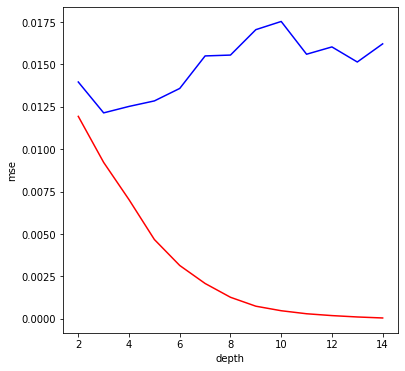

In [179]:
plt.figure(figsize=(6,6))
x = [i for i in range(2,15)]
plt.plot(x,avg_train,'r',label='train')
plt.plot(x,avg_test,'b',label='test')
plt.xlabel('depth')
plt.ylabel('mse')
plt.show()

In [180]:
housing_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,1,2
0,1.000000,0.396564,4,2,3,1,0,0,0,1,2,1,0,1
1,0.909091,0.502405,4,4,4,1,0,0,0,1,3,0,0,1
2,0.909091,0.571134,3,2,2,1,0,1,0,0,2,1,1,0
3,0.906061,0.402062,4,2,2,1,0,1,0,1,3,1,0,1
4,0.836364,0.396564,4,1,2,1,1,1,0,1,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,0.006061,0.092784,2,1,1,1,0,1,0,0,2,0,0,0
541,0.001485,0.051546,3,1,1,0,0,0,0,0,0,0,1,0
542,0.000000,0.135395,2,1,1,1,0,0,0,0,0,0,0,0
543,0.000000,0.086598,3,1,1,0,0,0,0,0,0,0,0,1


## 1.4 + 1.5

In [181]:
# performing bagging 
from random import randrange

train = np.array(pd.concat([Y_train,X_train],axis=1))
test = np.array(pd.concat([Y_test,X_test],axis=1))
regressor = DecisionTreeRegressor(random_state=20,max_depth=4) 

def bagging(train,test,n_estimators=10):
  trees = list()
  train_scores = list()
  test_scores = list()
  for i in range(n_estimators):
    sample_x = list()
    sample_y = list()
    num_of_sam = 4*len(train)/5
    while(len(sample_x)<num_of_sam):
      index = randrange(len(train))
      sample_x.append(train[index][1:])
      sample_y.append(train[index][0])
    tree = regressor.fit(sample_x,sample_y)
    pred_train = regressor.predict(train[:,1:])
    actual_train = [row[0] for row in train]
    pred_test = regressor.predict(test[:,1:])
    actual_test = [row[0] for row in test]
    train_scores.append(error_r2(actual_train,pred_train))
    test_scores.append(error_r2(actual_test,pred_test))
  # print("Training set :",train_scores)
  # print("Average on train :",sum(train_scores)/len(train_scores))
  # print("Testing set :",test_scores)
  # print("Average on test :",sum(test_scores)/len(test_scores))
  return train_scores,test_scores

train_scores,test_scores = bagging(train,test)

## 1.6 + 1.7

In [182]:
print("Training set :",train_scores)
print("Average on train :",sum(train_scores)/len(train_scores))
print("Testing set :",test_scores)
print("Average on test :",sum(test_scores)/len(test_scores))

Training set : [0.6133036586378275, 0.6196657848142173, 0.6490857638403777, 0.5880177631220387, 0.5675962994090382, 0.607146279706509, 0.5441109583026367, 0.6369069011537991, 0.6212615143977899, 0.6201898833313233]
Average on train : 0.6067284806715558
Testing set : [0.3797747050188085, 0.353252039207393, 0.4193164210540711, 0.46009449424162074, 0.2858504197512257, 0.3918182923365747, 0.3368767797190222, 0.40007418444115017, 0.46402548953041123, 0.3221287253776097]
Average on test : 0.38132115506778874


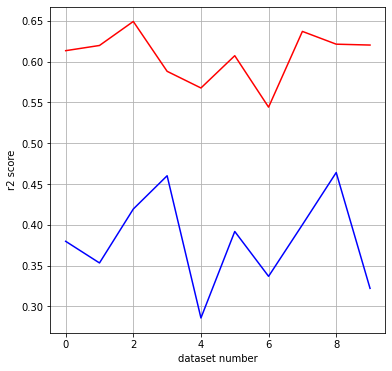

In [183]:
plt.figure(figsize=(6,6))
x = [i for i in range(10)]
plt.plot(x,train_scores,'r',label='train')
plt.plot(x,test_scores,'b',label='test')
plt.xlabel('dataset number')
plt.ylabel('r2 score')
plt.grid()
plt.show()

## 1.8

In [184]:
from random import randrange

train = np.array(pd.concat([Y_train,X_train],axis=1))
test = np.array(pd.concat([Y_test,X_test],axis=1))
 

def bagging(train,test,n_estimators=10):
  avg_scores = []
  for depth in range(2,10):
    trees = list()
    scores = list()
    regressor = DecisionTreeRegressor(max_depth=depth)
    for i in range(n_estimators):
      sample_x = list()
      sample_y = list()
      num_of_sam = 4*len(train)/5
      while(len(sample_x)<num_of_sam):
        index = randrange(len(train))
        sample_x.append(train[index][1:])
        sample_y.append(train[index][0])
      tree = regressor.fit(sample_x,sample_y)
      pred = regressor.predict(test[:,1:])
      actual = [row[0] for row in test]
      accuracy = error_r2(actual,pred)
      scores.append(accuracy)
    avg_scores.append(sum(scores)/len(scores))
    print("Average r2 at depth",depth,":",sum(scores)/len(scores))
  return avg_scores

avg_scores = bagging(train,test)
print("Max r2 :",max(avg_scores))

Average r2 at depth 2 : 0.32271147820207596
Average r2 at depth 3 : 0.36687599751091754
Average r2 at depth 4 : 0.3858900903904891
Average r2 at depth 5 : 0.3750371558272861
Average r2 at depth 6 : 0.3709257735907512
Average r2 at depth 7 : 0.34139910472522705
Average r2 at depth 8 : 0.38939127029119985
Average r2 at depth 9 : 0.33570859779623646
Max r2 : 0.38939127029119985


## 1.9

In [185]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

reg = RandomForestRegressor(n_estimators = 10)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print("r2 score :",r2_score(Y_test,Y_pred))
print("mae :",mean_absolute_error(Y_test,Y_pred))

r2 score : 0.5468406173594322
mae : 0.08200713476225671


## 1.10

In [186]:
from sklearn.ensemble import AdaBoostRegressor
abr = AdaBoostRegressor()
abr.fit(X_train, Y_train)
Y_pred = abr.predict(X_test)
print("r2 score :",r2_score(Y_test,Y_pred))
print("mae :",mean_absolute_error(Y_test,Y_pred))

r2 score : 0.5189161821609284
mae : 0.0903164942009857


# **Question 2**

## Pre-processing

In [187]:
bc_df = pd.read_csv('Breast_cancer_data.csv')
bc_df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [188]:
bc_df.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

In [189]:
bc_df.shape

(569, 6)

In [190]:
bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [191]:
bc_df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


In [192]:
bc_df.nunique()

mean_radius        456
mean_texture       479
mean_perimeter     522
mean_area          539
mean_smoothness    474
diagnosis            2
dtype: int64

## classification tree

In [194]:
bc_df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [195]:
df = bc_df[:]
df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [196]:
# calculating gini index
def gini_index(y):
    gini_index = 0
    labels = np.unique(y)
    for cls in labels:
        p = len(y[y == cls]) / len(y)
        gini_index += p**2
    return 1 - gini_index

#information gain for two subtrees
def info_gain(parent, l_child, r_child):
        giniGain = gini_index(parent) - ((len(l_child) / len(parent))*gini_index(l_child) + (len(r_child) / len(parent))*gini_index(r_child))
        return giniGain

# changing continuous values to categorical values by checking maximum information gain
def cont_to_cat(dataset,index, y):
  max_info_gain = -1e9
  best_split = {}
  poss_split_val = np.unique(df[y])
  for val in poss_split_val:
      dataset_left = np.array([x for x in dataset[y] if x <= val])
      dataset_right = np.array([x for x in dataset[y] if x  > val])
      if len(dataset_left)>0 and len(dataset_right)>0:
          curr_info_gain = info_gain(y, dataset_left, dataset_right)
          if curr_info_gain>max_info_gain:
              best_split["index"] = index
              best_split["val"] = val 
              max_info_gain = curr_info_gain
  df[y] = np.where(df[y]>best_split["val"], 1, 0)

for i in range(len(df.columns)):
  cont_to_cat(df,i,bc_df.columns[i])

for i in df.columns:
  print(df[i].value_counts())

1    355
0    214
Name: mean_radius, dtype: int64
1    354
0    215
Name: mean_texture, dtype: int64
0    516
1     53
Name: mean_perimeter, dtype: int64
0    487
1     82
Name: mean_area, dtype: int64
0    420
1    149
Name: mean_smoothness, dtype: int64
1    357
0    212
Name: diagnosis, dtype: int64


In [197]:
class Node():
    def __init__(self, feature_index=None, left=None, right=None, info_gain=None, value=None):
        
        # for decision node
        self.feature_index = feature_index
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

class Decision_tree_classifier():
    def __init__(self, max_depth=10):        
        self.root = None
        self.max_depth = max_depth

    def get_best_split(self, dataset, num_samples, num_features):
      best_split = {}
      max_info_gain = -float("inf")
      for index in range(0,num_features):
          feature_values = dataset[:, index]
          possible_thresholds = np.unique(feature_values)
          dataset_left = np.array(dataset[dataset[:,index]==0])
          dataset_right = np.array(dataset[dataset[:,index]==1])
          if (len(dataset_left)>0 and len(dataset_right)>0):
              y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
              curr_info_gain = info_gain(y, left_y, right_y)
              if curr_info_gain>max_info_gain:
                  best_split["feature_index"] = index
                  best_split["dataset_left"] = dataset_left
                  best_split["dataset_right"] = dataset_right
                  best_split["info_gain"] = curr_info_gain
                  max_info_gain = curr_info_gain
                      
      return best_split

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            try:
              if(best_split["info_gain"]>0):
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"],left_subtree, right_subtree, best_split["info_gain"])
            except:
              pass
        # when we reach a node, use majority voting for its prediction output
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def calculate_leaf_value(self, Y):        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root
        if tree.value is not None:
            print(tree.value)
        else:
            print("X_"+str(tree.feature_index), "=", "0", "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):        
        df = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(df)
    
    def predict(self, X):
        preditions = [self.make_prediction(elem, self.root) for elem in X]
        return preditions
    
    def make_prediction(self, x, tree):        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val==0:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    

## 2.1

In [198]:
def accuracy(a,b):
  right = wrong = 0
  for i in range(len(a)):
    if a[i]==b[i]:
      right+=1
    else:
      wrong+=1
  return (right)*100/(right+wrong)

In [199]:
# fitting the X_train and Y_train values in the classifier and storing the predictions in Y_pred
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
X_train,X_test,Y_train,Y_test = train_test_split(X, Y,train_size=0.7,random_state=32)

classifier = Decision_tree_classifier()
classifier.fit(X_train.values,Y_train.values.reshape(-1,1))

Y_pred = classifier.predict(X_test.values) 
print(accuracy(Y_pred,Y_test.values.reshape(-1,1)))
# classifier.print_tree()
# print(Y_pred)

80.70175438596492


## 2.2

In [200]:
train = pd.concat([Y_train,X_train],axis=1)
from random import sample,randrange
from sklearn.tree import DecisionTreeClassifier

def cross_val_split(data,folds):
  splits = []
  num_of_elements = int(data.shape[0]/ folds)
  df_copy = data
  for i in range(folds):
    fold = []
    while(len(fold)<num_of_elements):
      r = randrange(df_copy.shape[0])
      index = df_copy.index[r]
      fold.append(df_copy.loc[index].values.tolist())
      df_copy = df_copy.drop(index)
    splits.append(np.asarray(fold))
  return splits

def kfold_CV(data,folds,depth):
  df_data = cross_val_split(data,folds)
  avg_train = []
  avg_test = []
  for depth in range(2,depth):
    result_train = []
    result_test = []
    classifier_depth = DecisionTreeClassifier(max_depth=depth) 
    for i in range(folds):
      r = list(range(folds))
      r.pop(i)
      for j in r :
        if j == r[0]:
          cv = df_data[j]
        else:    
          cv=np.concatenate((cv,df_data[j]), axis=0)
      # print(cv.shape)
      classifier_depth.fit(cv[:,1:],cv[:,0].reshape(-1,1))
      x_pred = classifier_depth.predict(cv[:,1:])
      x_act = cv[:,0]
      result_train.append(accuracy(x_act,x_pred))
      y_pred = classifier_depth.predict(df_data[i][:,1:])
      y_act = df_data[i][:,0]
      result_test.append(accuracy(y_act,y_pred))
    avg_train.append(sum(result_train)/folds)
    avg_test.append(sum(result_test)/folds)
    print("Depth :",depth)
    print("MSE of each fold :",result_test)
    print("Average of folds :",sum(result_test)/folds)
  print("Maximum",max(avg_test),"at max_depth",avg_test.index(max(avg_test))+2)
  return avg_train,avg_test
   
avg_train,avg_test = kfold_CV(train,5,15)

Depth : 2
MSE of each fold : [79.74683544303798, 77.21518987341773, 70.88607594936708, 77.21518987341773, 74.68354430379746]
Average of folds : 75.9493670886076
Depth : 3
MSE of each fold : [81.0126582278481, 88.60759493670886, 86.07594936708861, 74.68354430379746, 86.07594936708861]
Average of folds : 83.29113924050633
Depth : 4
MSE of each fold : [81.0126582278481, 83.54430379746836, 78.48101265822785, 77.21518987341773, 86.07594936708861]
Average of folds : 81.26582278481013
Depth : 5
MSE of each fold : [81.0126582278481, 83.54430379746836, 78.48101265822785, 77.21518987341773, 86.07594936708861]
Average of folds : 81.26582278481013
Depth : 6
MSE of each fold : [81.0126582278481, 83.54430379746836, 78.48101265822785, 77.21518987341773, 86.07594936708861]
Average of folds : 81.26582278481013
Depth : 7
MSE of each fold : [81.0126582278481, 83.54430379746836, 78.48101265822785, 77.21518987341773, 86.07594936708861]
Average of folds : 81.26582278481013
Depth : 8
MSE of each fold : [81.0

## 2.3

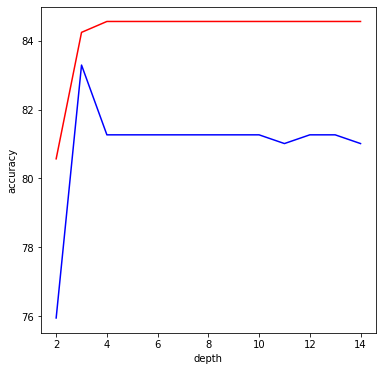

In [201]:
plt.figure(figsize=(6,6))
x = [i for i in range(2,15)]
plt.plot(x,avg_train,'r',label='train')
plt.plot(x,avg_test,'b',label='test')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.show()

## 2.4

In [202]:
bc_df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [255]:
X = bc_df.iloc[:, :-1]
Y = bc_df.iloc[:, -1]
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3,random_state=13)
X_train

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
491,17.850,13.23,114.60,992.1,0.07838
18,19.810,22.15,130.00,1260.0,0.09831
392,15.490,19.97,102.40,744.7,0.11600
73,13.800,15.79,90.43,584.1,0.10070
393,21.610,22.28,144.40,1407.0,0.11670
...,...,...,...,...,...
153,11.150,13.08,70.87,381.9,0.09754
528,13.940,13.17,90.31,594.2,0.12480
74,12.310,16.52,79.19,470.9,0.09172
176,9.904,18.06,64.60,302.4,0.09699


In [256]:
!pip install xgboost

In [257]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(subsample=0.7,max_depth=4)
xgb_class.fit(X_train,Y_train) 

XGBClassifier(max_depth=4, subsample=0.7)

## 2.5

In [258]:
from sklearn.metrics import accuracy_score
xgb_pred_train = xgb_class.predict(X_train)
xgb_pred_test = xgb_class.predict(X_test)
print("accuracy on training set :",accuracy_score(Y_train,xgb_pred_train))
print("accuracy on testing set :",accuracy_score(Y_test,xgb_pred_test))

accuracy on training set : 0.9824120603015075
accuracy on testing set : 0.9239766081871345


## 2.6 + 2.7

In [259]:
!pip install lightgbm

In [260]:
import lightgbm as lgb
train_leaves_acc = []
test_leaves_acc = []
for i in range(2,25):
  lgb_class = lgb.LGBMClassifier(max_depth=4,num_leaves=i) # keeping max_depth as 4
  lgb_class.fit(X_train,Y_train)
  lgb_pred_train = lgb_class.predict(X_train)
  lgb_pred_test = lgb_class.predict(X_test)
  train_leaves_acc.append(accuracy_score(Y_train,lgb_pred_train))
  test_leaves_acc.append(accuracy_score(Y_test,lgb_pred_test))

In [261]:
train_leaves_acc

[0.957286432160804,
 0.957286432160804,
 0.9773869346733668,
 0.9874371859296482,
 0.9899497487437185,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297,
 0.9974874371859297]

In [262]:
test_leaves_acc

[0.9181286549707602,
 0.9239766081871345,
 0.9298245614035088,
 0.9298245614035088,
 0.935672514619883,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088,
 0.9298245614035088]

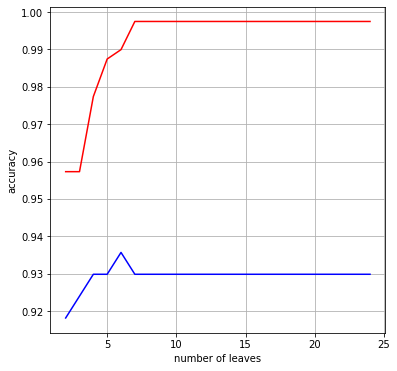

In [263]:
plt.figure(figsize=(6,6))
x = [i for i in range(2,25)]
plt.plot(x,train_leaves_acc,'r')
plt.plot(x,test_leaves_acc,'b')
plt.xlabel('number of leaves')
plt.ylabel('accuracy')
plt.grid()
plt.show()
# for max_depth=5, the model starts overfitting after num_leaves = 5

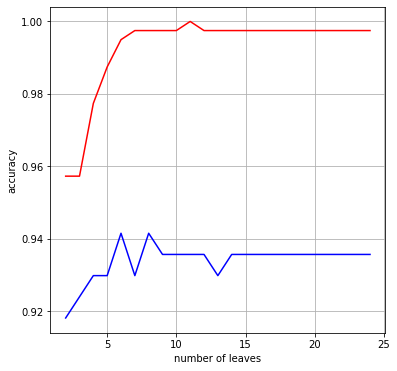

In [264]:
train_leaves_acc = []
test_leaves_acc = []
for i in range(2,25):
  lgb_class = lgb.LGBMClassifier(max_depth=5,num_leaves=i) # keeping max depth as 5
  lgb_class.fit(X_train,Y_train)
  lgb_pred_train = lgb_class.predict(X_train)
  lgb_pred_test = lgb_class.predict(X_test)
  train_leaves_acc.append(accuracy_score(Y_train,lgb_pred_train))
  test_leaves_acc.append(accuracy_score(Y_test,lgb_pred_test))

plt.figure(figsize=(6,6))
x = [i for i in range(2,25)]
plt.plot(x,train_leaves_acc,'r')
plt.plot(x,test_leaves_acc,'b')
plt.xlabel('number of leaves')
plt.ylabel('accuracy')
plt.grid()
plt.show()

## 2.8

In [265]:
import lightgbm as lgb
# keeping application as binary as it is used to predict a binary output
train_leaves_acc = []
test_leaves_acc = []
for i in range(2,25):
  lgb_class = lgb.LGBMClassifier(max_depth=4,num_leaves=i,application='binary')
  lgb_class.fit(X_train,Y_train)
  lgb_pred_train = lgb_class.predict(X_train)
  lgb_pred_test = lgb_class.predict(X_test)
  train_leaves_acc.append(accuracy_score(Y_train,lgb_pred_train))
  test_leaves_acc.append(accuracy_score(Y_test,lgb_pred_test))

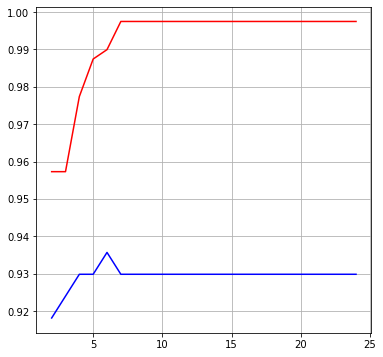

In [266]:
plt.figure(figsize=(6,6))
x = [i for i in range(2,25)]
plt.plot(x,train_leaves_acc,'r')
plt.plot(x,test_leaves_acc,'b')
plt.grid()
plt.show()

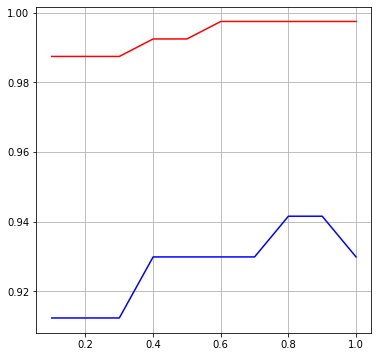

In [272]:
import lightgbm as lgb
# changing feature_fraction
train_leaves_acc = []
test_leaves_acc = []
for i in range(1,11):
  lgb_class = lgb.LGBMClassifier(max_depth=4,application='binary',feature_fraction=i/10)
  lgb_class.fit(X_train,Y_train)
  lgb_pred_train = lgb_class.predict(X_train)
  lgb_pred_test = lgb_class.predict(X_test)
  train_leaves_acc.append(accuracy_score(Y_train,lgb_pred_train))
  test_leaves_acc.append(accuracy_score(Y_test,lgb_pred_test))

plt.figure(figsize=(6,6))
x = [i/10 for i in range(1,11)]
plt.plot(x,train_leaves_acc,'r')
plt.plot(x,test_leaves_acc,'b')
plt.grid()
plt.show()

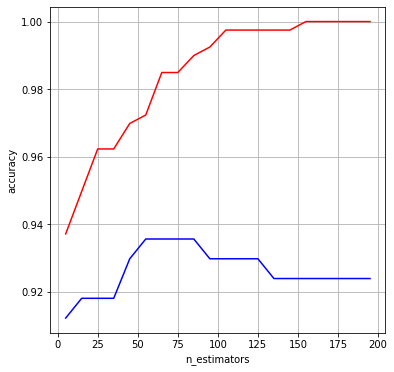

In [271]:
## tuning n-estimators/num-iterations
train_acc = []
test_acc = []
for i in range(5,200,10):
  lgb_class = lgb.LGBMClassifier(max_depth=4,application='binary',n_estimators=i)
  lgb_class.fit(X_train,Y_train)
  lgb_pred_train = lgb_class.predict(X_train)
  lgb_pred_test = lgb_class.predict(X_test)
  train_acc.append(accuracy_score(Y_train,lgb_pred_train))
  test_acc.append(accuracy_score(Y_test,lgb_pred_test))

plt.figure(figsize=(6,6))
x = [i for i in range(5,200,10)]
plt.plot(x,train_acc,'r')
plt.plot(x,test_acc,'b')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.grid()
plt.show()